In [1]:
# import pandas as pd
# import numpy as np
# import lightgbm as lgb
# import matplotlib.pyplot as plt
# import seaborn as sns
# import warnings
# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
# from sklearn.metrics import make_scorer
# warnings.filterwarnings('ignore')

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("dataset_hosp_vacc.csv", parse_dates=["Date"])
test = pd.read_csv("dataset_hosp_vacc_test.csv", parse_dates=["Date"])
# sample_sub = pd.read_csv('demand_forecasting_datasets/sample_submission.csv')
df = pd.concat([train, test], sort=False)

df.head()

date_column = "Date" 
target_column= "new_hospitalized_patients"
feature_column_1 = "location_key"
feature_column_2 = "new_persons_vaccinated"
# date column name must me "date"

# #load dataset
# train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
# test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
# df = pd.concat([train, test], sort=False) # veri önişleme için test ve train bir araya getirdim
# df.head()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196448 entries, 0 to 13631
Data columns (total 16 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   Unnamed: 0                             196448 non-null  int64         
 1   Date                                   196448 non-null  datetime64[ns]
 2   location_key                           196448 non-null  object        
 3   new_hospitalized_patients              182816 non-null  float64       
 4   cumulative_hospitalized_patients       191901 non-null  float64       
 5   current_hospitalized_patients          182816 non-null  float64       
 6   new_intensive_care_patients            178035 non-null  float64       
 7   cumulative_intensive_care_patients     178035 non-null  float64       
 8   current_intensive_care_patients        182816 non-null  float64       
 9   current_ventilator_patients            182816 non

In [5]:
df.dtypes


Unnamed: 0                                        int64
Date                                     datetime64[ns]
location_key                                     object
new_hospitalized_patients                       float64
cumulative_hospitalized_patients                float64
current_hospitalized_patients                   float64
new_intensive_care_patients                     float64
cumulative_intensive_care_patients              float64
current_intensive_care_patients                 float64
current_ventilator_patients                     float64
new_persons_vaccinated                            int64
cumulative_persons_vaccinated                     int64
new_persons_fully_vaccinated                      int64
cumulative_persons_fully_vaccinated               int64
new_vaccine_doses_administered                  float64
cumulative_vaccine_doses_administered           float64
dtype: object

In [6]:
# date key field column name 
# date column name must me "date"

In [7]:
print("Train set:",train.shape)
print("Test set:",test.shape)

Train set: (182816, 16)
Test set: (13632, 8)


In [8]:
# combining the training and test dataset
# df = train +test


df.drop(['cumulative_hospitalized_patients','new_intensive_care_patients','cumulative_intensive_care_patients'], axis=1, inplace=True)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


In [9]:
# using quantile function -transform a numeric input variable to have a different data distribution


df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,0.00,0.05,0.25,0.50,0.75,0.95,0.99,1.00
new_hospitalized_patients,0.0,0.0,0.0,0.0,3.00,55.00,400.00,11246.0
current_hospitalized_patients,0.0,0.0,0.0,0.0,0.00,0.00,78.85,5390.0
current_intensive_care_patients,0.0,0.0,0.0,0.0,0.00,0.00,11.00,947.0
current_ventilator_patients,0.0,0.0,0.0,0.0,0.00,0.00,3.00,557.0
new_persons_vaccinated,-350160.0,0.0,1.0,8.0,45.00,3746.30,49346.49,2118821.0
cumulative_persons_vaccinated,0.0,5.0,635.0,2539.0,11327.00,1430258.65,9669134.16,174333400.0
new_persons_fully_vaccinated,-233678.0,0.0,0.0,5.0,35.00,2120.00,36719.67,1600527.0
cumulative_persons_fully_vaccinated,0.0,0.0,191.0,1246.0,6379.00,654110.25,7957102.00,152340188.0
new_vaccine_doses_administered,-296286.0,0.0,4.0,21.0,99.00,6827.00,86546.05,2979630.0
cumulative_vaccine_doses_administered,0.0,3.0,786.0,3604.5,16469.25,1385242.00,15924807.60,326673588.0


In [10]:


df[date_column].min()

Timestamp('2020-01-25 00:00:00')

In [11]:
df[date_column].max()

Timestamp('2022-12-03 00:00:00')

In [12]:
# 25% - The 25% percentile*.
# 50% - The 50% percentile*.
# 75% - The 75% percentile*.
# max - the maximum value.

# *Percentile meaning: how many of the values are less than the given percentile. Read more about percentiles in our Machine Learning Percentile chapter.

df[target_column].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])
# df["sales"].describe()

count    182816.000000
mean         23.715999
std         226.523171
min           0.000000
10%           0.000000
30%           0.000000
50%           0.000000
70%           2.000000
80%           4.000000
90%          15.000000
95%          55.000000
99%         400.000000
max       11246.000000
Name: new_hospitalized_patients, dtype: float64

In [13]:
# to find the number of unique values inthe column

unique_location_key_count = df[feature_column_1].nunique()

In [14]:

df[feature_column_2].nunique() 

10943

In [15]:
# grouping the store column and finding the count of unique items in each store


df.groupby([feature_column_1])[target_column].nunique()

location_key
AR          350
AR_A         57
AR_A_007      8
AR_A_014      4
AR_A_021      4
           ... 
BR_RR        38
BR_RS       328
BR_SC       264
BR_SE        96
BR_SP       572
Name: new_hospitalized_patients, Length: 580, dtype: int64

In [16]:
# group by 2 coumns and finding sales sum and other parameters like mean median and mode

df.groupby([feature_column_1]).agg({target_column: ["sum", "mean", "median", "std"],feature_column_2: ["sum", "mean", "median", "std"]})

new_hospitalized_patients                                new_persons_vaccinated                                     
                                   sum        mean median         std                    sum          mean   median           std
location_key                                                                                                                     
AR                            232643.0  537.281755  494.0  285.035539                7803686  15670.052209  10155.0  14193.124025
AR_A                            8491.0   21.940568   18.0   13.273101                 125071    303.570388    195.5    375.188099
AR_A_007                         253.0    0.773700    0.0    1.152822                   8169     23.406877     14.0     28.693597
AR_A_014                          73.0    0.270370    0.0    0.607460                   1155      3.969072      1.0      6.649014
AR_A_021                          64.0    0.226950    0.0    0.538468                   1434      4.764120      3.0      6.317767
...                                ...         ...    ...         ...                    ...           ...      ...           ...
BR_RR                           4662.0    7.459200    5.0    8.123960                 372636    581.335413      0.0   1459.914476
BR_RS                         113073.0  158.587658   99.0  184.288683                9637506  12532.517555      0.0  22221.724836
BR_SC                          74842.0  104.967742   71.0  106.901024                6288027   8198.209909      0.0  19220.451439
BR_SE                          17663.0   27.049005   19.0   26.827283                1893378   2760.026239      0.0   5269.703497
BR_SP                         526350.0  714.179104  540.0  678.697006               44892758  55767.401242  10691.0  96191.354060

[580 rows x 8 columns]

In [17]:
df['month'] = df.Date.dt.month

df['day_of_month'] = df.Date.dt.day

df['day_of_year'] = df.Date.dt.dayofyear 

df['week_of_year'] = df.Date.dt.weekofyear

df['day_of_week'] = df.Date.dt.dayofweek

df['year'] = df.Date.dt.year

df["is_wknd"] = df.Date.dt.weekday // 4

df['is_month_start'] = df.Date.dt.is_month_start.astype(int)

df['is_month_end'] = df.Date.dt.is_month_end.astype(int) 

In [18]:
df.head()

,Date,location_key,new_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,current_ventilator_patients,new_persons_vaccinated,cumulative_persons_vaccinated,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_vaccine_doses_administered,cumulative_vaccine_doses_administered,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2020-02-12,AU,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,2,12,43,7,2,2020,0,0,0
1,2020-02-13,AU,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,2,13,44,7,3,2020,0,0,0
2,2020-02-20,AU,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,2,20,51,8,3,2020,0,0,0
3,2020-02-26,BR,1.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,2,26,57,9,2,2020,0,0,0
4,2020-02-28,AU,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,2,28,59,9,4,2020,1,0,0


In [19]:
# month wise grouping

df.groupby([feature_column_1, "month"]).agg({target_column: ["sum", "mean", "median", "std"]})

new_hospitalized_patients                                 
                                         sum         mean  median         std
location_key month                                                           
AR           1                       36036.0   581.225806   574.5  113.777957
             2                       19841.0   367.425926   386.5  111.581699
             3                       16801.0   430.794872   477.0  139.916362
             4                       25348.0   844.933333   854.5  153.187497
             5                       32381.0  1044.548387  1045.0  161.952017
...                                      ...          ...     ...         ...
BR_SP        8                       34736.0   560.258065   523.0  232.440998
             9                       23871.0   397.850000   336.5  184.935520
             10                      16269.0   262.403226   212.0  149.040259
             11                      17357.0   289.283333   156.5  259.974972
             12                      21812.0   351.806452    91.5  383.679419

[6930 rows x 4 columns]

In [20]:
# random noise function 

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [21]:

# sorting according to date

df.sort_values(by=[feature_column_1, 'Date'], axis=0, inplace=True)
df.head()

,Date,location_key,new_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,current_ventilator_patients,new_persons_vaccinated,cumulative_persons_vaccinated,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_vaccine_doses_administered,cumulative_vaccine_doses_administered,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
957,2020-12-29,AR,594.0,0.0,0.0,0.0,2862,2862,0,0,2862.0,2862.0,12,29,364,53,1,2020,0,0,0
156451,2020-12-30,AR,553.0,0.0,0.0,0.0,2760,5622,0,0,2760.0,5622.0,12,30,365,53,2,2020,0,0,0
1032,2020-12-31,AR,403.0,0.0,0.0,0.0,378,6000,0,0,378.0,6000.0,12,31,366,53,3,2020,0,0,1
156511,2021-01-01,AR,450.0,0.0,0.0,0.0,15,6015,0,0,15.0,6015.0,1,1,1,53,4,2021,1,1,0
45943,2021-01-02,AR,575.0,0.0,0.0,0.0,410,6425,0,0,410.0,6425.0,1,2,2,53,5,2021,1,0,0


In [22]:
# lag features function 


def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby([feature_column_1])[target_column].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [23]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby([feature_column_1])[target_column]. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546, 730])

In [24]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby([feature_column_1])[target_column].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df.tail()

,Date,location_key,new_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,current_ventilator_patients,new_persons_vaccinated,cumulative_persons_vaccinated,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_vaccine_doses_administered,cumulative_vaccine_doses_administered,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
5101,2022-11-01,BR_SP,NaN,NaN,NaN,NaN,9833,38366729,29449,35671518,NaN,NaN,11,1,305,44,1,2022,0,1,0,NaN,12.922479,NaN,28.173810,132.622562,NaN,116.843228,1791.153624,562.635175,979.178540,271.263164,814.958315,941.334822,15.0019,12.0017,60.9987,30.0029,42.561871,246.115365,1754.515035,563.938807,979.723451,15.047344,12.042550,60.967331,30.072487,44.844007,247.081062,1761.140581,574.670050,974.898178,15.187503,12.170815,60.867309,30.290115,47.763170,249.413244,1770.098945,585.771987,969.523209,15.720236,12.693782,60.437450,31.173364,53.762821,257.828394,1786.727231,600.130831,960.765449,16.510858,13.606235,59.619813,32.742827,59.893433,271.412133,1796.268797,603.632481,953.517913,18.312522,17.001406,56.340870,39.345755,72.152638,315.780083,1778.058588,576.372677,934.128467
12994,2022-11-02,BR_SP,NaN,NaN,NaN,NaN,68292,40884877,18902,36327021,NaN,NaN,11,2,306,44,2,2022,0,0,0,23.871361,NaN,50.073792,NaN,109.542682,215.477536,97.521026,1638.590080,521.736460,930.957264,267.103167,808.733178,939.294373,24.9990,12.0017,52.0009,30.0029,38.045619,600.421154,1793.605150,521.429388,932.477235,24.975118,12.042550,52.022418,30.072487,38.342200,586.154053,1792.357029,523.683502,934.144909,24.901875,12.170815,52.088673,30.290115,38.976317,568.541324,1791.609894,527.477199,935.752321,24.628809,12.693782,52.337498,31.173364,41.152564,534.765679,1792.545446,536.826166,937.753090,24.235977,13.606235,52.685784,32.742827,44.568030,504.223640,1794.680639,545.789744,938.455374,23.328130,17.001406,53.085614,39.345755,55.076319,459.890041,1786.029294,548.686339,933.064233
13609,2022-11-03,BR_SP,NaN,NaN,NaN,NaN,26126,41614409,71371,37559576,NaN,NaN,11,3,307,44,3,2022,0,0,0,NaN,7.415057,NaN,20.445131,86.730877,214.570237,39.964056,1177.522258,318.581696,569.541952,262.842542,806.086867,937.415865,24.9990,9.0003,52.0009,21.0009,47.900456,464.374212,1641.536052,320.034294,572.634772,24.975118,9.007606,52.022418,21.

In [25]:


df = pd.get_dummies(df, columns=['day_of_week', 'month'])

In [26]:
# [feature_column_1, feature_column_2])[target_column

df[target_column] = np.log1p(df[target_column].values)

In [27]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['location_key'] = le.fit_transform(df['location_key'])
   


In [28]:

train = df.loc[(df[date_column] < "2022-01-01"), :]


val = df.loc[(df[date_column] >= "2020-01-25") & (df[date_column] < "2022-01-01"), :]


cols = [col for col in train.columns if col not in [date_column, 'id', target_column, "year"]]

In [29]:

Y_train = train[target_column]


X_train = train[cols]


Y_val = val[target_column]


X_val = val[cols] 


Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((169184,), (169184, 102), (169184,), (169184, 102))

In [30]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [31]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [32]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, 
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)


smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092528 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.465184	training's SMAPE: 143.459	valid_1's l1: 0.465184	valid_1's SMAPE: 143.459
[200]	training's l1: 0.382132	training's SMAPE: 143.025	valid_1's l1: 0.382132	valid_1's SMAPE: 143.025
[300]	training's l1: 0.35922	training's SMAPE: 142.449	valid_1's l1: 0.35922	valid_1's SMAPE: 142.449
[400]	training's l1: 0.348791	training's SMAPE: 141.921	valid_1's l1: 0.348791	valid_1's SMAPE: 141.921
[500]	training's l1: 0.342392	training's SMAPE: 141.437	valid_1's l1: 0.342392	valid_1's SMAPE: 141.437
[600]	training's l1: 0.337455	training's SMAPE: 141.065	valid_1's l1: 0.337455	valid_1's SMAPE: 141.065
[700]	training's l1: 0.333305	training's SMAPE: 140.772	valid_1's l1: 0.333305	valid_1's SMAPE: 140.772
[800]	training's l1: 0.329777	training's SMAPE:

[7300]	training's l1: 0.274707	training's SMAPE: 136.243	valid_1's l1: 0.274707	valid_1's SMAPE: 136.243
[7400]	training's l1: 0.274354	training's SMAPE: 136.214	valid_1's l1: 0.274354	valid_1's SMAPE: 136.214
[7500]	training's l1: 0.274061	training's SMAPE: 136.189	valid_1's l1: 0.274061	valid_1's SMAPE: 136.189
[7600]	training's l1: 0.273741	training's SMAPE: 136.16	valid_1's l1: 0.273741	valid_1's SMAPE: 136.16
[7700]	training's l1: 0.27348	training's SMAPE: 136.137	valid_1's l1: 0.27348	valid_1's SMAPE: 136.137
[7800]	training's l1: 0.273156	training's SMAPE: 136.11	valid_1's l1: 0.273156	valid_1's SMAPE: 136.11
[7900]	training's l1: 0.272829	training's SMAPE: 136.084	valid_1's l1: 0.272829	valid_1's SMAPE: 136.084
[8000]	training's l1: 0.27253	training's SMAPE: 136.057	valid_1's l1: 0.27253	valid_1's SMAPE: 136.057
[8100]	training's l1: 0.272176	training's SMAPE: 136.027	valid_1's l1: 0.272176	valid_1's SMAPE: 136.027
[8200]	training's l1: 0.271852	training's SMAPE: 136.002	valid_

135.5899366735696

In [33]:
#Final Model



train = df.loc[~df.new_hospitalized_patients.isna()]
Y_train = train[target_column]
X_train = train[cols]

test = df.loc[df.new_hospitalized_patients.isna()]
X_test = test[cols]

In [34]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

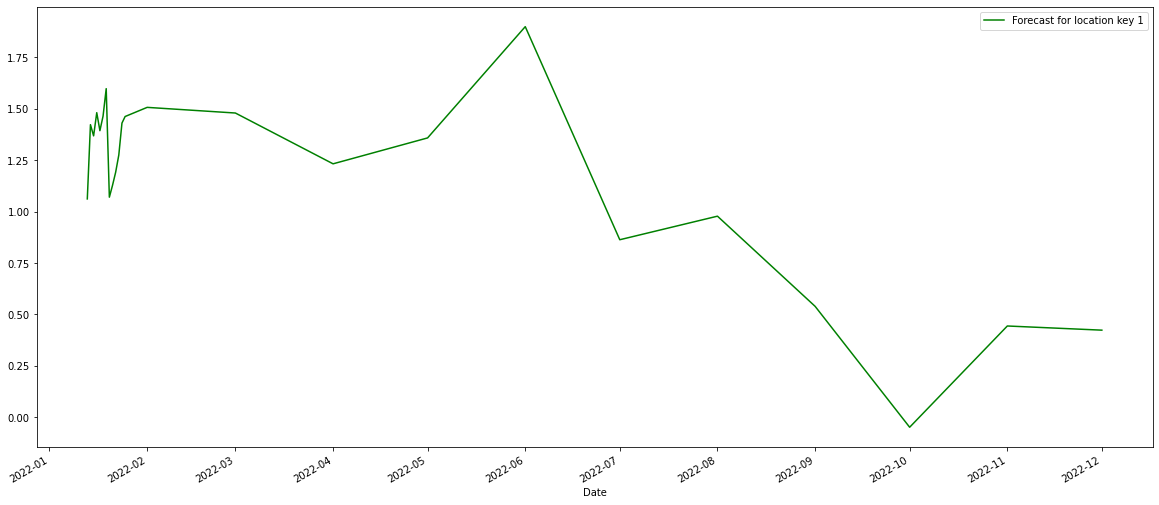

In [35]:
# [feature_column_1, feature_column_2])[target_column

forecast = pd.DataFrame({date_column:test[date_column],
                        feature_column_1:test[feature_column_1],
#                         feature_column_2:test[feature_column_2],
                        target_column:test_preds
                        })

forecast[(forecast[feature_column_1] == 100) ].set_index(date_column).new_hospitalized_patients.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Forecast for location key 1");

In [36]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [37]:
def f(x):
    input_location_key = x
    train[(train[feature_column_1] == input_location_key) ].set_index(date_column).new_hospitalized_patients.plot(figsize = (20,9),legend=True, label = "Training for location key = %i" % input_location_key)
    forecast[(forecast[feature_column_1] == input_location_key)].set_index(date_column).new_hospitalized_patients.plot(legend=True, label =  "Forecast for location key = %i" % input_location_key);

In [38]:
F1 = widgets.IntSlider(value=5, min=1, max=unique_location_key_count)

interactive(f,x=F1)


interactive(children=(IntSlider(value=5, description='x', max=580, min=1), Output()), _dom_classes=('widget-in…

In [39]:
df.shape

(196448, 105)

In [40]:
forecast[forecast[feature_column_1] == 1]

,Date,location_key,new_hospitalized_patients
83,2022-01-01,1,2.722072
6231,2022-01-13,1,3.469108
6653,2022-01-14,1,3.287573
7313,2022-01-15,1,3.244387
7568,2022-01-16,1,3.212132
8267,2022-01-17,1,3.572829
8409,2022-01-18,1,3.496284
9026,2022-01-19,1,3.576509
9783,2022-01-20,1,3.436160
10077,2022-01-21,1,3.376130
